#### Simulate the Positive,Negative and Random Sampling

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as geom
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt


In [2]:
def generate_grid_dataframe(grid_side_length, autocorrelation="positive", random_seed=42):
    """
    Generates a GeoDataFrame based on the grid size of one side with different types of spatial autocorrelation.
    
    Parameters:
        grid_side_length (int): The number of squares along one side of the grid.
        autocorrelation (str): Type of spatial autocorrelation. Options:
                               "none" - No spatial correlation (pure random)
                               "positive" - Spatially smoothed using a Gaussian filter
                               "negative" - Spatially negative correlation (inverted)
                               "cluster" - Clustered spatial pattern with defined centers
        random_seed (int): Random seed for reproducibility.

    Returns:
        GeoDataFrame: A GeoDataFrame containing square geometries and values based on the selected correlation.
    """
    np.random.seed(random_seed)  # Set the random seed for reproducibility

    num_squares = grid_side_length ** 2
    df = pd.DataFrame({'Index': np.arange(num_squares)})

    # Define grid size and statistical parameters
    grid_size = (grid_side_length, grid_side_length)
    mean, std_dev = 0.5, 0.125

    # Generate initial random values
    random_values = np.random.normal(mean, std_dev, grid_size)

    if autocorrelation == "none":
        values = random_values  # No spatial correlation

    elif autocorrelation == "positive":
        values = gaussian_filter(random_values, sigma=1.5)  # Apply Gaussian smoothing for spatial correlation

    elif autocorrelation == "negative":
        smoothed_values = gaussian_filter(random_values, sigma=1.5)
        checkerboard = np.indices(grid_size).sum(axis=0) % 2  # Create checkerboard pattern (alternating 0s and 1s)
        values = smoothed_values * (-1) ** checkerboard  # Flip alternating cells # This operation flips the sign of every other cell in a checkerboard pattern.
        # add background noise
        values += np.random.normal(0, 0.05, grid_size)

    elif autocorrelation == "cluster":
        # Generate clustered pattern
        values = np.zeros(grid_size)  # Start with zeros
        # Define cluster centers (example: 2 clusters)
        n_clusters = 2
        cluster_centers = np.random.randint(0, grid_side_length, (n_clusters, 2))
        cluster_radius = grid_side_length // 4  # Define cluster influence radius
        
        # Create distance-based clusters
        for center in cluster_centers:
            y, x = np.ogrid[:grid_size[0], :grid_size[1]]
            # Calculate distance from cluster center
            dist_from_center = np.sqrt((x - center[1])**2 + (y - center[0])**2)
            # Apply Gaussian decay within radius
            cluster_effect = np.exp(-dist_from_center**2 / (2 * cluster_radius**2))
            values += cluster_effect * np.random.normal(0.5, 0.2)  # Add cluster effect
        
        # Add background noise
        values += np.random.normal(0, 0.05, grid_size)

    else:
        raise ValueError("Invalid autocorrelation type. Choose from 'none', 'positive', 'negative', or 'cluster'.")

    # Assign values to the DataFrame
    df['Value'] = values.ravel()

    # Function to calculate square coordinates
    def calculate_square_coordinates(row):
        value = row['Index']
        x = value % grid_side_length
        y = value // grid_side_length
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

    # Convert to GeoDataFrame with square geometries
    df['geometry'] = df.apply(calculate_square_coordinates, axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')

    return gdf

# Example usage:
# gdf = generate_grid_dataframe(10, autocorrelation="cluster", random_seed=42)
# gdf.plot(column='Value', cmap='viridis')

In [3]:
grid_length = 12

gdf_none = generate_grid_dataframe(grid_length, autocorrelation="none", random_seed=42)        # No spatial correlation
gdf_positive = generate_grid_dataframe(grid_length, autocorrelation="positive", random_seed=42)  # Positive spatial correlation
gdf_negative = generate_grid_dataframe(grid_length, autocorrelation="negative", random_seed=42)  # Negative spatial correlation
gdf_cluster = generate_grid_dataframe(grid_length, autocorrelation="cluster", random_seed=42)  # Clustered spatial correlation


# print the sum of the values in each grid
print(f"Sum of values in the grid with no spatial correlation: {gdf_none['Value'].sum()}")
print(f"Sum of values in the grid with positive spatial correlation: {gdf_positive['Value'].sum()}")
print(f"Sum of values in the grid with negative spatial correlation: {gdf_negative['Value'].sum()}")
print(f"Sum of values in the grid with clustered spatial correlation: {gdf_cluster['Value'].sum()}")



Sum of values in the grid with no spatial correlation: 70.54346816827575
Sum of values in the grid with positive spatial correlation: 70.54346816827575
Sum of values in the grid with negative spatial correlation: 0.4328642610294613
Sum of values in the grid with clustered spatial correlation: 23.511408569723365


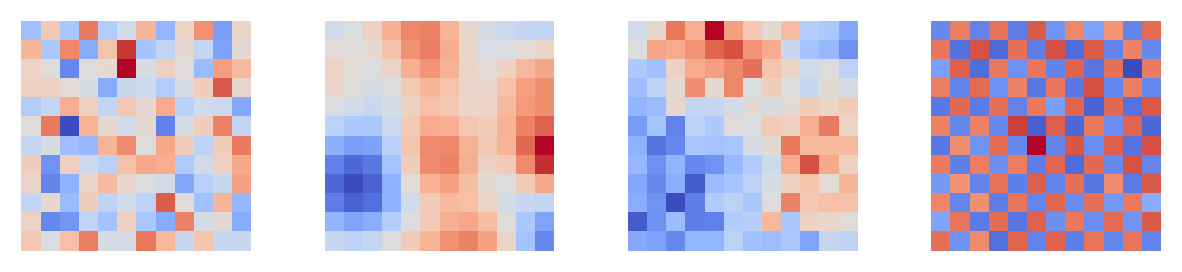

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot each GeoDataFrame and remove axes
gdf_none.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[0])
gdf_positive.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[1])
gdf_cluster.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[2])
gdf_negative.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[3])

# Remove axes
for ax in axs:
    ax.set_axis_off()

plt.show()


In [6]:
gdf_positive.describe()

,Index,Value
count,144.000000,144.000000
mean,71.500000,0.489885
std,41.713307,0.020692
min,0.000000,0.434485
25%,35.750000,0.479790
50%,71.500000,0.491894
75%,107.250000,0.504737
max,143.000000,0.537495


In [7]:
# min max scaling
gdf_positive['Value'] = (gdf_positive['Value'] - gdf_positive['Value'].min()) / (gdf_positive['Value'].max() - gdf_positive['Value'].min()) 

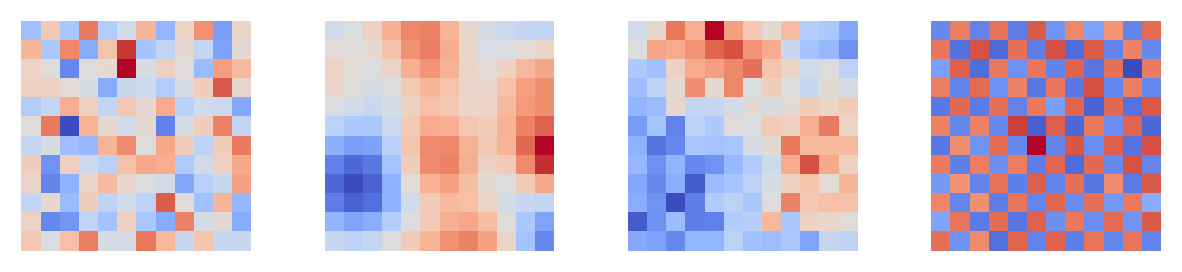

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot each GeoDataFrame and remove axes
gdf_none.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[0])
gdf_positive.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[1])
gdf_cluster.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[2])
gdf_negative.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[3])

# Remove axes
for ax in axs:
    ax.set_axis_off()

plt.show()

In [9]:
gdf_positive.describe()

,Index,Value
count,144.000000,144.000000
mean,71.500000,0.537811
std,41.713307,0.200876
min,0.000000,0.000000
25%,35.750000,0.439812
50%,71.500000,0.557309
75%,107.250000,0.681988
max,143.000000,1.000000


In [11]:
from utills.geodata import generate_grid_dataframe,calculate_moran_i

from utills.adjacency_simplex import AdjacencySimplex 
from utills.calculate_tda_summaries import compute_persistence

In [10]:
# scaling factor
scaling_factor = [1, 2, 3, 4 ,5, 6, 7, 8, 9, 10]

In [12]:

results_df = pd.DataFrame(columns=['Scaling Factor','Filter Method','TL','AL','TML','AML'])

for scaling_value in scaling_factor:
    
    gdf_temp = gdf_positive.copy()
    gdf_temp['Value'] = gdf_temp['Value'] * scaling_value

    for filter_method in ['up','down']:

        # Initialize the AdjacencySimplex class
        adj_simplex = AdjacencySimplex(gdf_temp, 'Value', threshold = None, filter_method = filter_method)

        # Filter the GeoDataFrame
        filtered_df,gdf_id = adj_simplex.filter_sort_gdf()

        # Calculate the adjacent countries
        adj_simplex.calculate_adjacent_countries()

        # Form the simplicial complex
        simplex = adj_simplex.form_simplicial_complex()

        # Compute the persistence
        _,TL, AL, TML, AML,_ = compute_persistence(simplices=simplex,filtered_df=filtered_df,variable_name='Value')

        # Add the results to the results_df
        new_row = pd.DataFrame({'Scaling Factor': [scaling_value],
                                   'Filter Method': [filter_method],
                                   'TL': [TL],
                                   'AL': [AL],
                                   'TML': [TML],
                                   'AML': [AML]})
        results_df = pd.concat([results_df,new_row],ignore_index=True)



/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_65484/724836872.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,new_row],ignore_index=True)


In [14]:
results_df_up = results_df[results_df['Filter Method'] == 'up']
results_df_down = results_df[results_df['Filter Method'] == 'down'] 

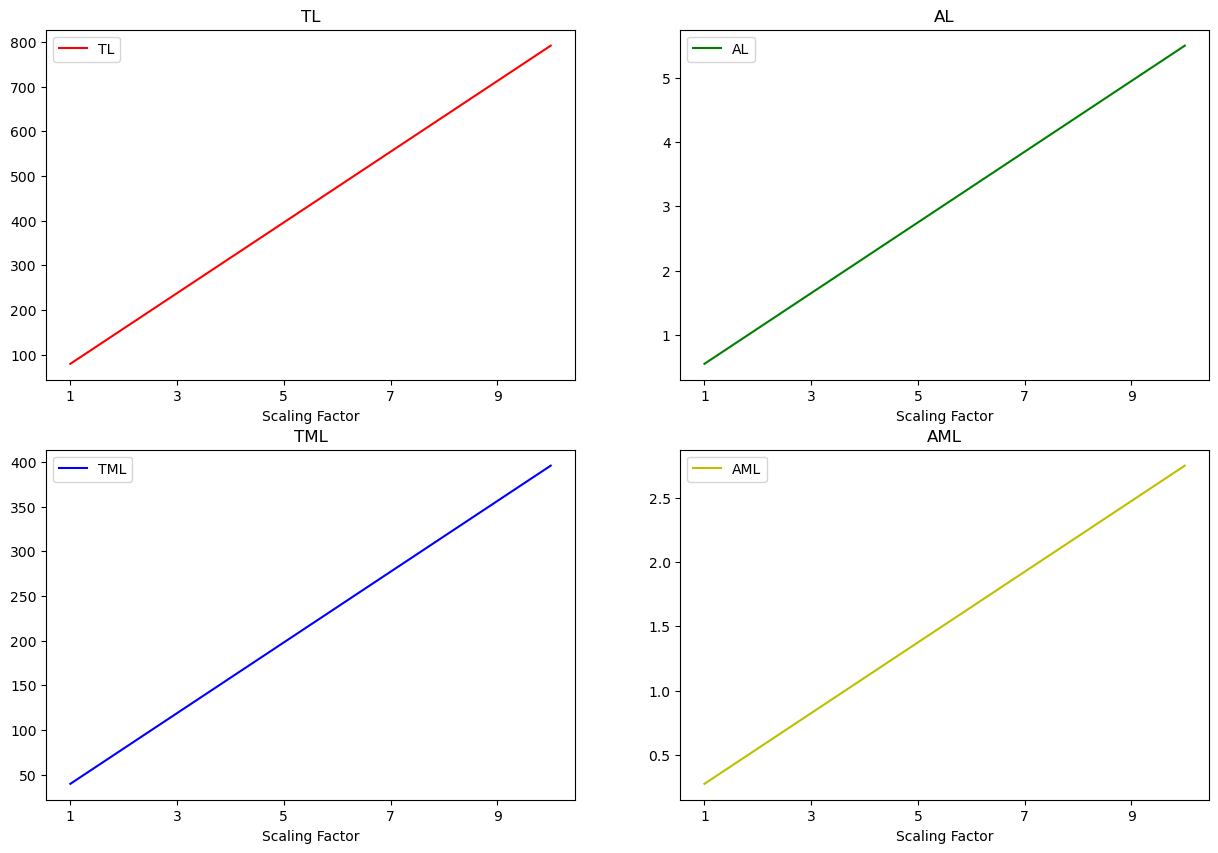

In [15]:
# plot X-axis scaling factor, Y-axis TL, AL, TML, AML
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

results_df_up.plot(x='Scaling Factor', y='TL', ax=axs[0,0], title='TL', color='r')
results_df_up.plot(x='Scaling Factor', y='AL', ax=axs[0,1], title='AL', color='g')
results_df_up.plot(x='Scaling Factor', y='TML', ax=axs[1,0], title='TML', color='b')
results_df_up.plot(x='Scaling Factor', y='AML', ax=axs[1,1], title='AML', color='y')

plt.show()

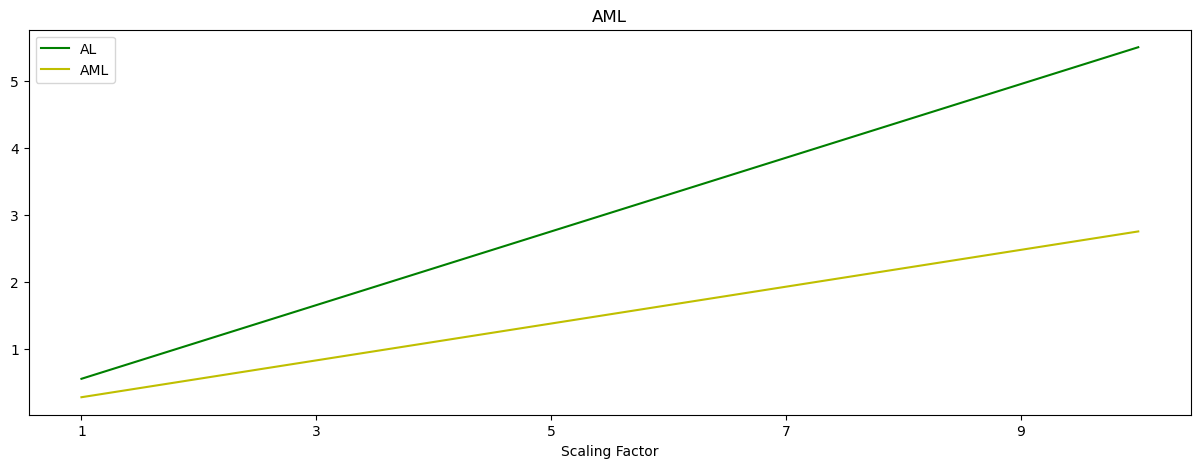

In [20]:
# plot up at same plot
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

# results_df_up.plot(x='Scaling Factor', y='TL', ax=axs[0], title='TL', color='r')
results_df_up.plot(x='Scaling Factor', y='AL', ax=axs, title='AL', color='g')
# results_df_up.plot(x='Scaling Factor', y='TML', ax=axs[1], title='TML', color='b')
results_df_up.plot(x='Scaling Factor', y='AML', ax=axs, title='AML', color='y')

plt.show()

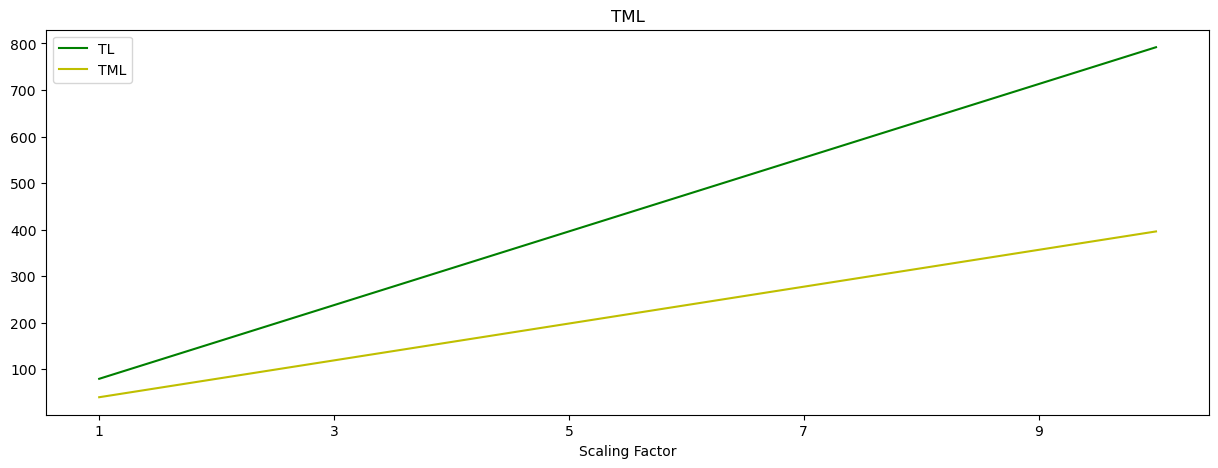

In [21]:
# plot up at same plot
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

# results_df_up.plot(x='Scaling Factor', y='TL', ax=axs[0], title='TL', color='r')
results_df_up.plot(x='Scaling Factor', y='TL', ax=axs, title='TL', color='g')
# results_df_up.plot(x='Scaling Factor', y='TML', ax=axs[1], title='TML', color='b')
results_df_up.plot(x='Scaling Factor', y='TML', ax=axs, title='TML', color='y')

plt.show()

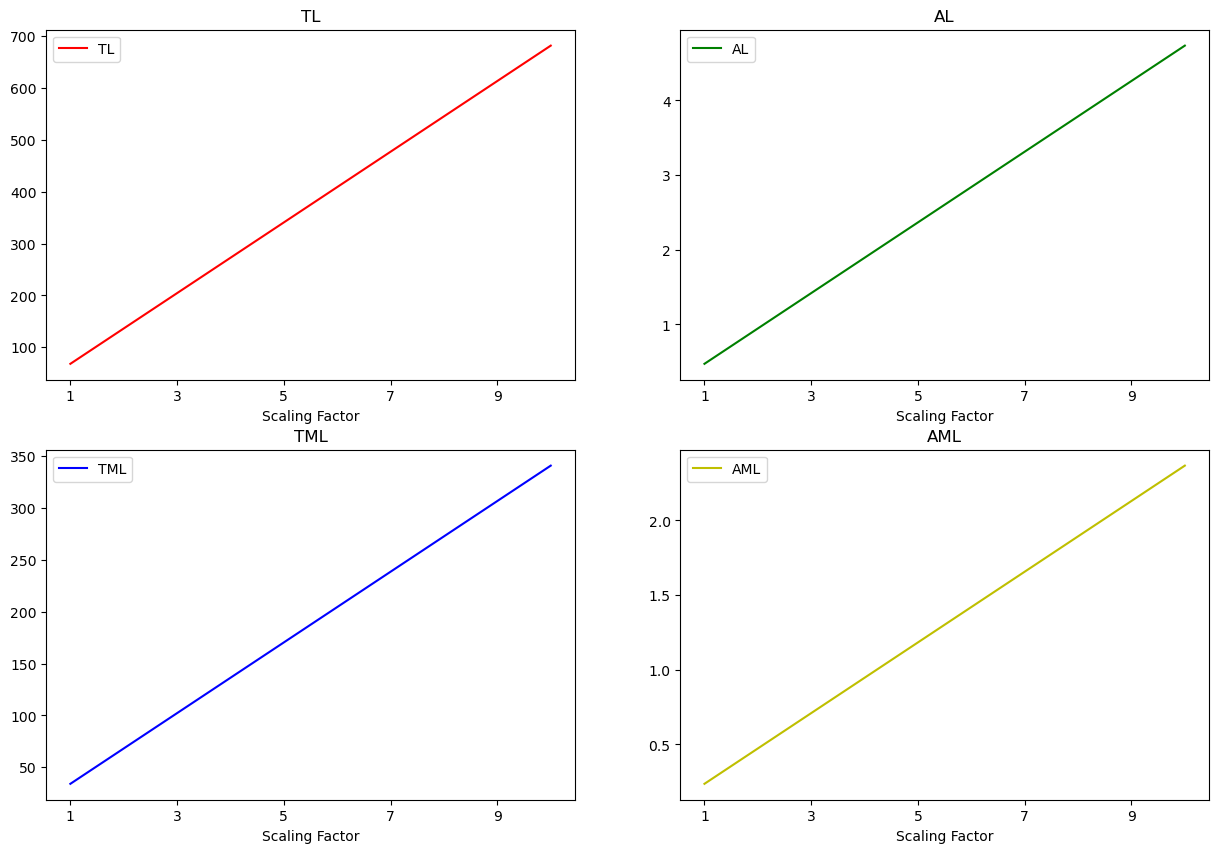

In [16]:
# plot X-axis scaling factor, Y-axis TL, AL, TML, AML
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

results_df_down.plot(x='Scaling Factor', y='TL', ax=axs[0,0], title='TL', color='r')
results_df_down.plot(x='Scaling Factor', y='AL', ax=axs[0,1], title='AL', color='g')
results_df_down.plot(x='Scaling Factor', y='TML', ax=axs[1,0], title='TML', color='b')
results_df_down.plot(x='Scaling Factor', y='AML', ax=axs[1,1], title='AML', color='y')

plt.show()